# Calculate RXE for public dataset, females only based on Apua's script

In [1]:
import re
import functools
import numpy as np
import pandas as pd
from os import environ
from plotnine import *
from gtfparse import read_gtf
from warnings import filterwarnings
from scipy.stats import mannwhitneyu
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
environ['NUMEXPR_MAX_THREADS'] = '10'

In [4]:
config = {
    'pheno_file': '../../../input/phenotypes/_m/phenotypes.csv',
    'insert_size': '../../../input/gene_tpm/_m/picard_insert_size_metrics.csv',
    'gtf': '/ceph/genome/human/gencode26/gtf.ALL/_m/gencode.v26.chr_patch_hapl_scaff.annotation.gtf',
}

In [5]:
@functools.lru_cache()
def get_pheno():
    return pd.read_csv(config['pheno_file'], index_col=0)


@functools.lru_cache()
def get_insert_size():
    return pd.read_csv(config['insert_size'], index_col=0)


@functools.lru_cache()
def get_gtf(gtf_file):
    return read_gtf(gtf_file)

In [6]:
def gene_annotation():
    gtf0 = get_gtf(config['gtf'])
    gtf = gtf0[gtf0["feature"] == "gene"]
    return gtf[["gene_id", "gene_name", "seqname", "start", "end", "strand"]]


def chrom_type(chrom):
    if chrom=='chrX':
        return 'X'
    elif re.search('^chr(\d+)$', chrom):
        return 'autosome'
    else:
        return 'other'
    
    
def save_ggplot(p, fn):
    for ext in ['.pdf', '.png', '.svg']:
        p.save(fn+ext, width=10, height=7)
        

def rge(df, chrom):
    return df[df['seqname']==chrom][samples].mean() \
    - df[(df['chrom_type']=='autosome') & (df['seqname']!=chrom)][samples].mean()


In [7]:
gene_annot = gene_annotation()
gene_annot.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


,gene_id,gene_name,seqname,start,end,strand
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,+
12,ENSG00000227232.5,WASH7P,chr1,14404,29570,-
25,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,-
28,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,+
36,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,+


In [8]:
log2tpm = pd.read_csv('../../../input/gene_tpm/_m/log2tpm.csv', index_col=0)
log2tpm.iloc[0:2, 0:5]

,R12864,R12865,R12866,R12867,R12868
Geneid,,,,,
ENSG00000223972.5,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232.5,2.294585,2.349649,2.983534,2.694415,2.364178


In [9]:
df0 = log2tpm.merge(gene_annot.loc[:, ["gene_id", "gene_name", "seqname"]], 
                    left_index=True, right_on="gene_id")
df0['chrom_type'] = df0['seqname'].apply(chrom_type)
df0.shape

(51740, 1443)

In [10]:
df0.groupby('chrom_type').size()

chrom_type
X            1818
autosome    44719
other        5203
dtype: int64

In [11]:
samples = [x for x in log2tpm.columns if re.match('R\d+', x)]
df = df0[(df0[samples].sum(axis=1) >= 0.2 * len(samples)) & (df0['chrom_type'] != 'other')]

df1  = df.groupby('chrom_type').mean().transpose()
df1['sample'] = df1.index
df1['RXE'] = df1['X'] - df1['autosome']
df1.head(2)

chrom_type,X,autosome,sample,RXE
R12864,3.076746,2.791519,R12864,0.285227
R12865,3.201302,2.986970,R12865,0.214332


In [12]:
df2 = df1.merge(get_pheno().loc[:, ['Sex', 'Dx', 'Region']], left_index=True, right_index=True)
df2.loc[:, ['Region', 'Sex', 'RXE']].groupby(['Region', 'Sex']).describe()

RXE                                                    \
             count      mean       std       min       25%       50%   
Region  Sex                                                            
Caudate F    121.0  0.201658  0.080121 -0.010120  0.160207  0.218018   
        M    273.0  0.201201  0.062586 -0.053587  0.177907  0.211707   
DLPFC   F    114.0  0.221461  0.061893  0.028849  0.202148  0.242446   
        M    246.0  0.217834  0.038949  0.038942  0.199114  0.221585   
HIPPO   F    121.0  0.225148  0.052878  0.069767  0.194949  0.229280   
        M    255.0  0.217129  0.049547  0.072521  0.192701  0.222089   

                                 
                  75%       max  
Region  Sex                      
Caudate F    0.261447  0.316335  
        M    0.246972  0.317737  
DLPFC   F    0.261521  0.314081  
        M    0.244747  0.291408  
HIPPO   F    0.261691  0.332028  
        M    0.245014  0.358289

In [13]:
from scipy.stats import variation

In [14]:
for tissue in ['Caudate', 'DLPFC', 'HIPPO']:
    for sex in ['F', 'M']:
        var = variation(df2[(df2['Region']==tissue) & (df2['Sex']==sex)].RXE)
        print("There is %.3f variation for %s in %s." % (var, sex, tissue))

There is 0.396 variation for F in Caudate.
There is 0.310 variation for M in Caudate.
There is 0.278 variation for F in DLPFC.
There is 0.178 variation for M in DLPFC.
There is 0.234 variation for F in HIPPO.
There is 0.228 variation for M in HIPPO.


### Separate out tissues

In [15]:
caudate = df2[(df2['Region']=='Caudate')].copy()
dlpfc = df2[(df2['Region']=='DLPFC')].copy()
hippo = df2[(df2['Region']=='HIPPO')].copy()

In [16]:
for tissue in ['caudate', 'DLPFC', "hippocampus"]:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    stat, pval = mannwhitneyu(df_config[tissue][(df_config[tissue]['Sex']=='F')].RXE, 
                              df_config[tissue][(df_config[tissue]['Sex']=='M')].RXE)
    print("Mann-WhitneyU for female vs male (RXE) for %s: %.4f" % (tissue, pval))

Mann-WhitneyU for female vs male (RXE) for caudate: 0.1118
Mann-WhitneyU for female vs male (RXE) for DLPFC: 0.0017
Mann-WhitneyU for female vs male (RXE) for hippocampus: 0.0523


In [17]:
for tissue in ['caudate', 'DLPFC', "hippocampus"]:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    stat, pval = mannwhitneyu(df_config[tissue][(df_config[tissue]['Dx']=='Control')].RXE, 
                              df_config[tissue][(df_config[tissue]['Dx']=='Schizo')].RXE)
    print("Mann-WhitneyU for ctl vs sz (RXE) for %s: %.2e" % (tissue, pval))

Mann-WhitneyU for ctl vs sz (RXE) for caudate: 4.18e-01
Mann-WhitneyU for ctl vs sz (RXE) for DLPFC: 2.02e-01
Mann-WhitneyU for ctl vs sz (RXE) for hippocampus: 3.83e-05


In [18]:
for tissue in ['caudate', 'DLPFC', "hippocampus"]:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    female = df_config[tissue][(df_config[tissue]['Sex']=='F')].copy()
    male = df_config[tissue][(df_config[tissue]['Sex']=='M')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].RXE, 
                                  female[(female['Dx']=='Schizo')].RXE)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].RXE, 
                                  male[(male['Dx']=='Schizo')].RXE)
    print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f" % (tissue, pval_f))
    print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f" % (tissue, pval_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for caudate: 0.1962
Mann-WhitneyU of male, ctl vs sz (RXE) for caudate: 0.1802
Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.2686
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.2438
Mann-WhitneyU of female, ctl vs sz (RXE) for hippocampus: 0.0164
Mann-WhitneyU of male, ctl vs sz (RXE) for hippocampus: 0.0003


### X chromosome expression differences

In [20]:
for tissue in ['caudate', 'DLPFC', "hippocampus"]:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    female = df_config[tissue][(df_config[tissue]['Sex']=='F')].copy()
    male = df_config[tissue][(df_config[tissue]['Sex']=='M')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].X, 
                                  female[(female['Dx']=='Schizo')].X)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].X, 
                                  male[(male['Dx']=='Schizo')].X)
    print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f" % (tissue, pval_f))
    print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f" % (tissue, pval_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for caudate: 0.0321
Mann-WhitneyU of male, ctl vs sz (RXE) for caudate: 0.1929
Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.0383
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.0203
Mann-WhitneyU of female, ctl vs sz (RXE) for hippocampus: 0.0510
Mann-WhitneyU of male, ctl vs sz (RXE) for hippocampus: 0.0005


### Autosome expression

In [22]:
for tissue in ['caudate', 'DLPFC', "hippocampus"]:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    female = df_config[tissue][(df_config[tissue]['Sex']=='F')].copy()
    male = df_config[tissue][(df_config[tissue]['Sex']=='M')].copy()
    stat_f, pval_f = mannwhitneyu(female[(female['Dx']=='Control')].autosome, 
                                  female[(female['Dx']=='Schizo')].autosome)
    stat_m, pval_m = mannwhitneyu(male[(male['Dx']=='Control')].autosome, 
                                  male[(male['Dx']=='Schizo')].autosome)
    print("Mann-WhitneyU of female, ctl vs sz (RXE) for %s: %.4f" % (tissue, pval_f))
    print("Mann-WhitneyU of male, ctl vs sz (RXE) for %s: %.4f" % (tissue, pval_m))

Mann-WhitneyU of female, ctl vs sz (RXE) for caudate: 0.1135
Mann-WhitneyU of male, ctl vs sz (RXE) for caudate: 0.1579
Mann-WhitneyU of female, ctl vs sz (RXE) for DLPFC: 0.0072
Mann-WhitneyU of male, ctl vs sz (RXE) for DLPFC: 0.0069
Mann-WhitneyU of female, ctl vs sz (RXE) for hippocampus: 0.0574
Mann-WhitneyU of male, ctl vs sz (RXE) for hippocampus: 0.0041


### Interaction model

In [20]:
df2.Sex = df2.Sex.astype("category").cat.rename_categories({"F": "Female", "M": "Male"})
df2.Dx = df2.Dx.astype("category").cat.rename_categories({"Schizo": "SZ", "Control": "CTL"})
df2.head(2)

,X,autosome,sample,RXE,Sex,Dx,Region
R12864,3.076746,2.791519,R12864,0.285227,Female,SZ,Caudate
R12865,3.201302,2.986970,R12865,0.214332,Male,SZ,Caudate


In [23]:
df3 = df2[['RXE', 'Sex', 'Dx', 'Region']]
df3.Sex = df3.Sex.cat.codes
df3.Dx = df3.Dx.cat.codes
df3.Region = df3.Region.astype("category").cat.codes
df3.head(2)

,RXE,Sex,Dx,Region
R12864,0.285227,0,1,0
R12865,0.214332,1,1,0


In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = df2.loc[:,['RXE','Sex','Dx','Region']]

# ANOVA results with combinations of 2 groups:
formula = 'RXE ~ C(Sex) + C(Dx) + C(Region) + C(Sex):C(Dx) + C(Sex):C(Region) + C(Dx):C(Region)'
lm = ols(formula, anova_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df          F    PR(>F)
C(Sex)            0.005023     1.0   1.594365  0.206966
C(Dx)             0.036769     1.0  11.670248  0.000658
C(Region)         0.081754     2.0  12.974264  0.000003
C(Sex):C(Dx)      0.005657     1.0   1.795461  0.180534
C(Sex):C(Region)  0.003553     2.0   0.563890  0.569153
C(Dx):C(Region)   0.028744     2.0   4.561611  0.010640
Residual          3.528694  1120.0        NaN       NaN


#### By tissue interaction

In [75]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Assumes parametric

for tissue in ['caudate', 'DLPFC', "hippocampus"]:
    df_config = {'caudate': caudate,
                 'DLPFC': dlpfc, 
                 'hippocampus': hippo}
    anova_df = df_config[tissue].loc[:, ['RXE', 'Sex', 'Dx']]
    # ANOVA results with combinations of 2 groups:
    formula = 'RXE ~ C(Sex) + C(Dx) + C(Sex):C(Dx)'
    lm = ols(formula, anova_df).fit()
    table = sm.stats.anova_lm(lm, typ=2)
    print(tissue)
    print(table)
    print("\n")
    anova_df['combination'] = anova_df.Sex.astype("str") + " / " + anova_df.Dx.astype("str")
    anova_df['combination'] = anova_df.Sex.astype("str") + " / " + anova_df.Dx.astype("str")
    # perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=anova_df['RXE'], groups=anova_df['combination'], alpha=0.05)
    # coerce the tukeyhsd table to a DataFrame
    tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
    if tukey_data[(tukey_data['p-adj'] < 0.05)].shape[0] == 0:
        print("There is no significant interactions!")
    else:
        print(tukey_data[(tukey_data['p-adj'] < 0.05)])
    print("\n")

caudate
                sum_sq     df         F    PR(>F)
C(Sex)        0.000029    1.0  0.006205  0.937254
C(Dx)         0.001563    1.0  0.333410  0.563991
C(Sex):C(Dx)  0.005784    1.0  1.233748  0.267364
Residual      1.828405  390.0       NaN       NaN


There is no significant interactions!


DLPFC
                sum_sq     df         F    PR(>F)
C(Sex)        0.001069    1.0  0.474628  0.491314
C(Dx)         0.002436    1.0  1.081793  0.299003
C(Sex):C(Dx)  0.000603    1.0  0.267795  0.605136
Residual      0.801500  356.0       NaN       NaN


There is no significant interactions!


hippocampus
                sum_sq     df          F        PR(>F)
C(Sex)        0.007208    1.0   2.988436  8.469084e-02
C(Dx)         0.061027    1.0  25.302216  7.641565e-07
C(Sex):C(Dx)  0.000824    1.0   0.341619  5.592505e-01
Residual      0.897235  372.0        NaN           NaN


        group1      group2  meandiff  p-adj   lower   upper  reject
2  F / Control  M / Schizo   -0.0358  0.001 -

### Plot RXE

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


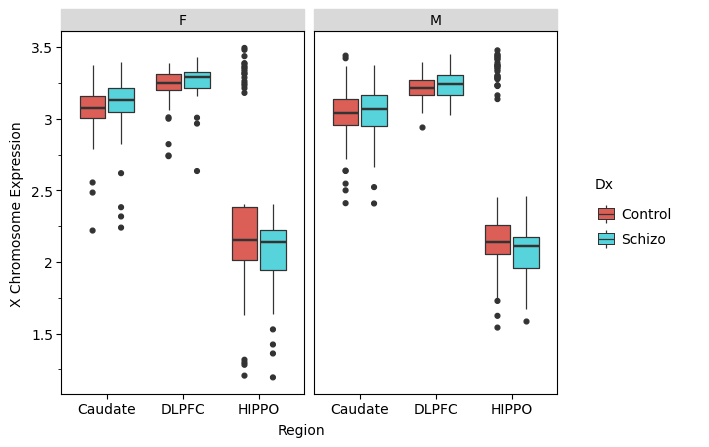

<ggplot: (8741766934929)>

In [23]:
p = ggplot(df2, aes(x='Region', y='X', fill='Dx')) \
+ geom_boxplot() \
+ facet_grid("~Sex")\
+ ylab("X Chromosome Expression")\
+ theme_matplotlib()
p

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


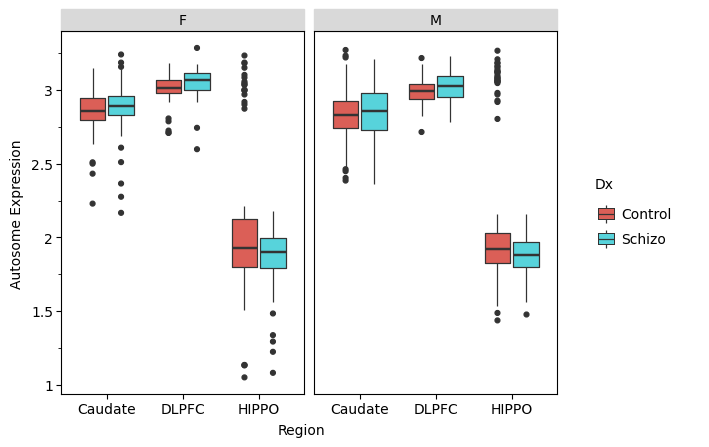

<ggplot: (8741762867869)>

In [24]:
p = ggplot(df2, aes(x='Region', y='autosome', fill='Dx')) \
+ geom_boxplot() \
+ facet_grid("~Sex")\
+ ylab("Autosome Expression")\
+ theme_matplotlib()
p

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


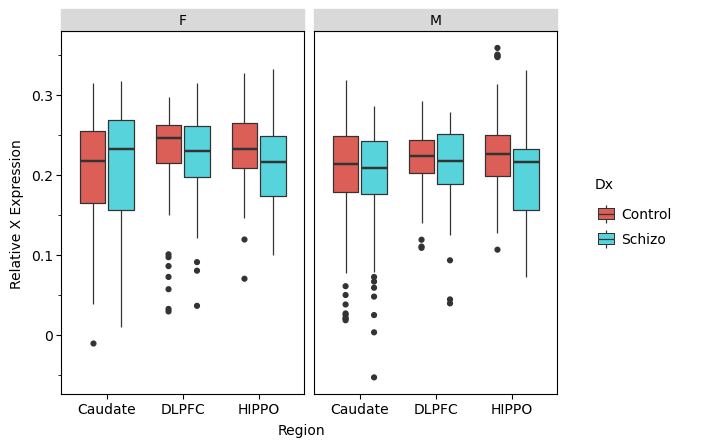

<ggplot: (8741763149945)>

In [25]:
p = ggplot(df2, aes(x='Region', y='RXE', fill='Dx')) \
+ geom_boxplot() \
+ facet_grid("~Sex")\
+ ylab("Relative X Expression")\
+ theme_matplotlib()
p

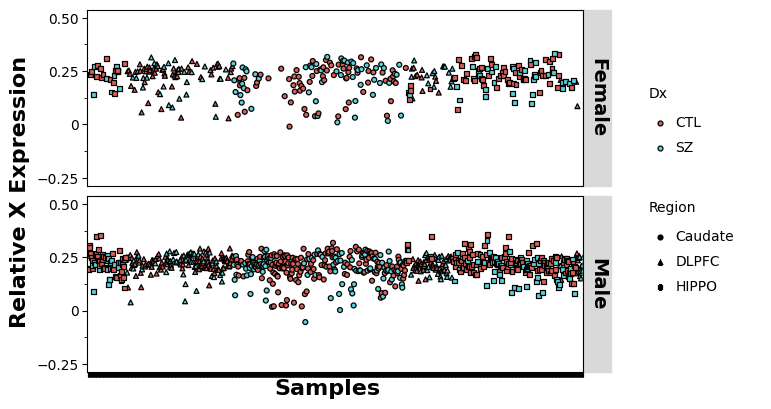

<ggplot: (8775992110939)>

In [34]:
p = ggplot(df2, aes(x='sample', y='RXE', fill='Dx', shape='Region')) \
+ geom_point() + ylim([-0.25, 0.5]) + xlab("Samples")\
+ ylab("Relative X Expression") + facet_grid("Sex~.")\
+ theme_matplotlib() \
+ theme(axis_text_x=element_blank(), 
        axis_text=element_text(size=13), 
        legend_title=element_text(size=15, face="bold"), 
        legend_text=element_text(size=13),
        axis_title=element_text(size=16, face="bold"), 
        strip_text=element_text(size=14, face="bold"))
p

In [46]:
df2.to_csv('RXE_public.csv')
save_ggplot(p, "RXE_public_bySex")

## Other chromosomes

In [49]:
for chrom in range(1,23):
    df1['RGE%d' % chrom] = rge(df, 'chr%d' % chrom)
    

rge = df1[[x for x in df1.columns if 'RGE' in x or 'RXE' in x]]
rge.head()

chrom_type,RXE,RGE1,RGE2,RGE3,RGE4,RGE5,RGE6,RGE7,RGE8,RGE9,...,RGE13,RGE14,RGE15,RGE16,RGE17,RGE18,RGE19,RGE20,RGE21,RGE22
R12864,0.285227,0.137221,0.048619,0.124203,0.027022,-0.024265,0.115749,0.079887,-0.063178,0.074716,...,-0.172205,-0.025920,-0.355004,-0.280154,-0.038059,-0.450791,0.023306,0.273079,-0.339813,-0.009248
R12865,0.214332,0.159906,0.027248,0.110844,0.018940,-0.032238,0.098431,0.073774,-0.114831,0.140709,...,-0.226386,-0.045472,-0.388450,-0.279795,0.002795,-0.489906,0.066002,0.247618,-0.319956,-0.032715
R12866,0.206535,0.118070,0.045938,0.113388,-0.056158,-0.049249,0.039514,0.094366,-0.098518,0.143308,...,-0.173592,-0.024457,-0.294699,-0.214212,-0.020374,-0.488748,0.060728,0.256096,-0.285757,0.029614
R12867,0.144386,0.102819,0.063515,0.147857,0.012888,-0.003432,0.069605,0.044507,-0.058054,0.137344,...,-0.117058,-0.047924,-0.277289,-0.212308,-0.045132,-0.396895,-0.044963,0.208471,-0.227589,-0.047968
R12868,0.071929,0.096117,-0.028140,0.085753,-0.073615,-0.100151,-0.013239,0.074740,-0.100097,0.127300,...,-0.202173,-0.055316,-0.310054,-0.062115,0.014727,-0.442377,0.146204,0.246068,-0.163413,0.126474


In [50]:
rge2 = rge.stack().reset_index()
rge2.columns = ['sample', 'var', 'value']
var2 = pd.Categorical(rge2['var'], categories=['RXE'] +  ['RGE%d' % chrom for chrom in range(1,23)])
rge2 = rge2.assign(var2 = var2)
rge2 = rge2.merge(get_pheno().loc[:, ['Sex', 'Dx']], left_on='sample', right_index=True)
rge2.head()

,sample,var,value,var2,Sex,Dx
0,R12864,RXE,0.285227,RXE,F,Schizo
1,R12864,RGE1,0.137221,RGE1,F,Schizo
2,R12864,RGE2,0.048619,RGE2,F,Schizo
3,R12864,RGE3,0.124203,RGE3,F,Schizo
4,R12864,RGE4,0.027022,RGE4,F,Schizo


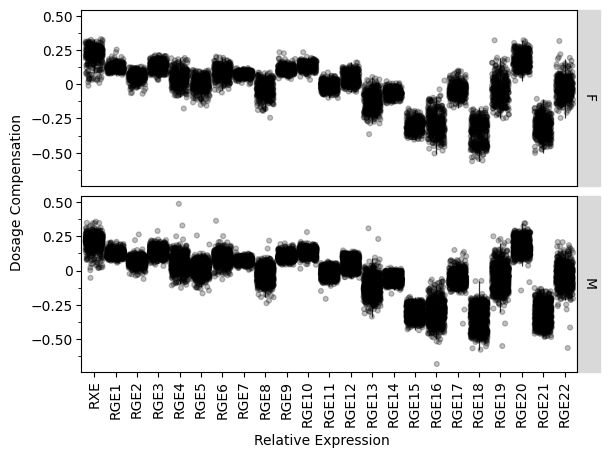

<ggplot: (8766146105992)>

In [71]:
pp = ggplot(rge2, aes(x='var2', y='value')) \
+ geom_boxplot(outlier_alpha=0) \
+ geom_jitter(alpha=0.25) + facet_grid('Sex~')\
+ ylab("Dosage Compensation") + xlab("Relative Expression")\
+ theme_matplotlib() \
+ theme(axis_text_x=element_text(rotation=90))
pp

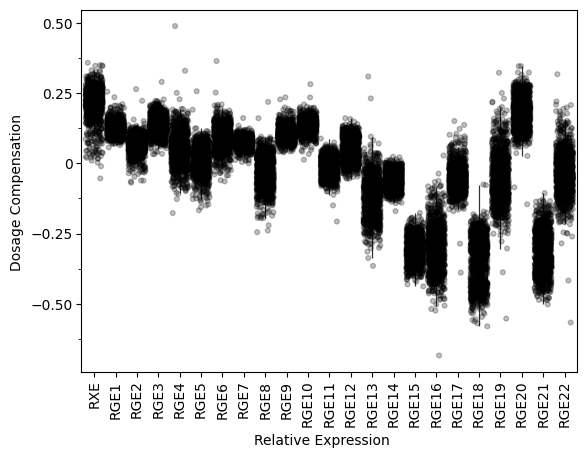

<ggplot: (8766178297953)>

In [54]:
ww = ggplot(rge2, aes(x='var2', y='value')) \
+ geom_boxplot(outlier_alpha=0) \
+ geom_jitter(alpha=0.25) \
+ ylab("Dosage Compensation") + xlab("Relative Expression")\
+ theme_matplotlib() \
+ theme(axis_text_x=element_text(rotation=90))
ww

In [43]:
rge.to_csv('RGE_public.csv')
save_ggplot(pp, "RGE_public_subset")
save_ggplot(ww, "RGE_public_all")